In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import descartes
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime


In [3]:
url_covid = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
covid = pd.read_csv(url_covid, dtype={'fips' : 'str'})
covid.date = pd.to_datetime(covid.date)
territories = ['Northern Mariana Islands', 'Guam', 'Virgin Islands', 'Puerto Rico', 'American Samoa', 'N. Mariana Islands']
# 'Alaska', 'Hawaii'
covid = covid.loc[~covid.state.isin(territories)]
offset_date = pd.to_datetime('2020-03-13')
covid = covid.loc[covid.date >= offset_date]


In [4]:
url_demographics = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv"
demographics = pd.read_csv(url_demographics, encoding = "ISO-8859-1")
demographics = demographics.loc[demographics.STATE != 0]
demographics.rename(columns={'NAME':'state', 'POPESTIMATE2019': 'population'}, inplace = True)

In [5]:
data = demographics.merge(covid, on = 'state')
data['relative_cases'] = data.cases / data.population
relative_cases = data.pivot(index='date', columns='state', values='relative_cases').fillna(0)


In [6]:
orders = pd.read_csv('shelter_order.csv', usecols = [0, 1, 2], names = ['state', 'emergency_date','order_date'], skiprows=1)
orders.rename(columns={'order_date': 'shelter_date'}, inplace=True)
orders.shelter_date = pd.to_datetime(orders.shelter_date + '-2020', format='%d-%b-%Y', errors='coerce')
orders.emergency_date = pd.to_datetime(orders.emergency_date + '-2020', format='%d-%b-%Y', errors='coerce')
orders = orders.loc[~orders.state.isin(territories)]
orders.set_index('state', inplace=True)

In [17]:
def plot_covid_progress(states, title='Covid19 progress by state\nwith shelter-in-place order dates'):
    ax = relative_cases[states].plot(figsize=(10, 5), linewidth=3)
    for s, line in zip(states, ax.get_lines()):
        shelter_date = orders.loc[s].shelter_date
        if pd.notna(shelter_date):
            ax.axvline(shelter_date, linestyle='--', color=line.get_color())
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Date', fontsize=15)
    ax.set_ylabel('# new cases / population size', fontsize=15)


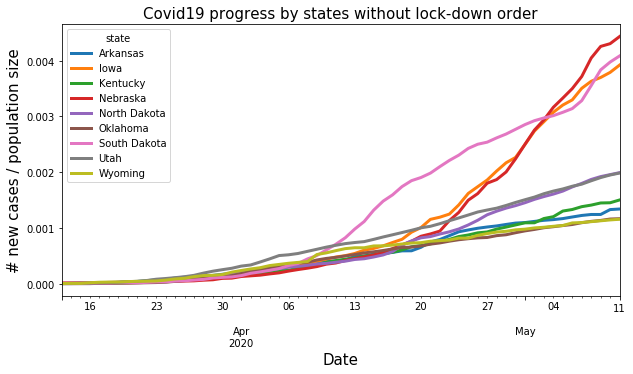

In [19]:
unsheltered_states = orders.index[orders.shelter_date.isna()].difference(['Massachusetts']).to_list()
plot_covid_progress(unsheltered_states, title='Covid19 progress by states without lock-down order')


In [21]:
def plot_covid_progress_comparison(state):
    last_shelter_date = orders.shelter_date.max()
    shelter_date = orders.loc[state].shelter_date
    comparison_date = shelter_date if pd.notna(shelter_date) else last_shelter_date
    states_sorted_by_relative_cases = relative_cases.loc[comparison_date].sort_values().index.to_list()
    idx = states_sorted_by_relative_cases.index(state)
    if idx - 2 < 0:
        lower_idx, upper_idx = 0, 5
    elif idx + 3 > len(relative_cases.columns):
        lower_idx, upper_idx = -5, len(relative_cases.columns)
    else:
        lower_idx, upper_idx = idx - 2, idx + 3
    comparable_states = states_sorted_by_relative_cases[lower_idx:upper_idx]
    plot_covid_progress(comparable_states)


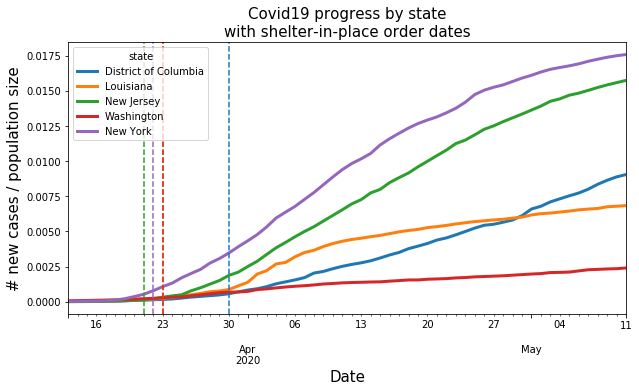

In [22]:
plot_covid_progress_comparison('New York')

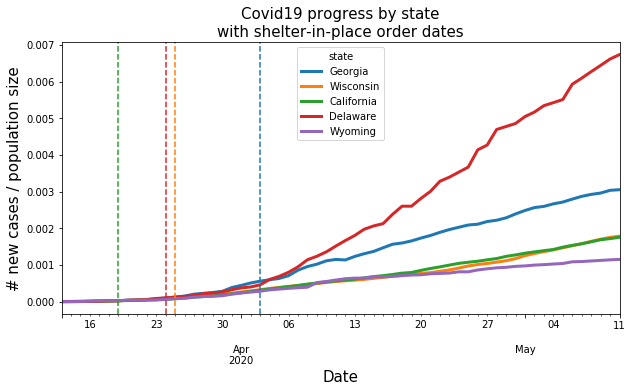

In [23]:
plot_covid_progress_comparison('California')

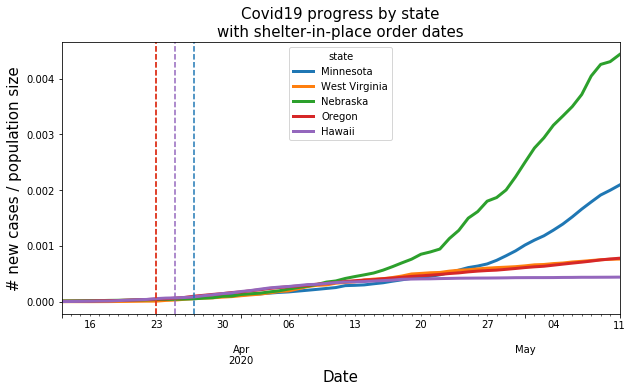

In [24]:
plot_covid_progress_comparison('Nebraska')

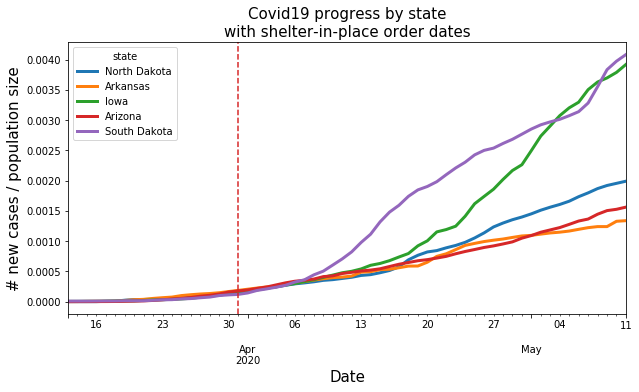

In [25]:
plot_covid_progress_comparison('Iowa')